In [2]:
import pandas as pd

YEARS = [2018, 2019]

data = pd.DataFrame()

#ingest
for year in YEARS:
    data = data.append(pd.read_csv(f"data/play_by_play_cleaned_{year}.csv.gz", compression='gzip', low_memory=False).reset_index(drop=True), sort=True)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
data.reset_index(drop=True, inplace=True)

In [3]:
data.loc[ (data.play_type!="no_play") ].reset_index(drop=True, inplace=True)
data['wp'] = data['wp'].apply(lambda x: x*100)

In [35]:
import numpy as np
def epa_success(epa):
    return 1 if epa>0 else 0
buckets = 10
wp_bins = pd.IntervalIndex.from_tuples([(100//buckets*i, 100//buckets*(i+1)) for i in range(buckets)])
data['wp'] = pd.cut(data['wp'], wp_bins)

runs = data.loc[(data.play_type=='run')]
passes = data.loc[(data.play_type=='pass')]
sea_runs = runs.loc[(data.posteam=='SEA')]
sea_passes = passes.loc[(data.posteam=='SEA')]

run_aggs = runs.groupby(['season', 'wp']).agg(
                    play_count = ('play_id', 'count'),
                    avg_epa = ('epa', 'mean'),
                    epa_succ_rate = ('epa', lambda x: (x.map(epa_success).mean()))).round(2)
pass_aggs = passes.groupby(['season', 'wp']).agg(
                    play_count = ('play_id', 'count'),
                    avg_epa = ('epa', 'mean'),
                    epa_succ_rate = ('epa', lambda x: (x.map(epa_success).mean()))).round(2)
sea_pass_aggs = sea_passes.groupby(['season', 'wp']).agg(
                    play_count = ('play_id', 'count'),
                    avg_epa = ('epa', 'mean'),
                    epa_succ_rate = ('epa', lambda x: (x.map(epa_success).mean()))).round(2)
sea_run_aggs = sea_runs.groupby(['season', 'wp']).agg(
                    play_count = ('play_id', 'count'),
                    avg_epa = ('epa', 'mean'),
                    epa_succ_rate = ('epa', lambda x: (x.map(epa_success).mean()))).round(2)
all = (run_aggs.join(pass_aggs, lsuffix='_run', rsuffix='_pass')).join(sea_run_aggs.join(sea_pass_aggs, lsuffix='_run', rsuffix='_pass'), lsuffix='_lg', rsuffix='_sea') 
all.reset_index(inplace=True)
all.loc[all.season==2018]
# all_run = run_aggs.join(sea_run_aggs, lsuffix='_lg', rsuffix='_sea')
# all_pass = pass_aggs.join(sea_pass_aggs, lsuffix='_lg', rsuffix='_sea')

,season,wp,play_count_run_lg,avg_epa_run_lg,epa_succ_rate_run_lg,play_count_pass_lg,avg_epa_pass_lg,epa_succ_rate_pass_lg,play_count_run_sea,avg_epa_run_sea,epa_succ_rate_run_sea,play_count_pass_sea,avg_epa_pass_sea,epa_succ_rate_pass_sea
10,2019,"(0, 10]",816,-0.06,0.42,3595,-0.04,0.45,17,0.04,0.53,109,0.15,0.50
11,2019,"(10, 20]",882,-0.06,0.42,2086,0.01,0.44,36,-0.31,0.33,67,0.21,0.55
12,2019,"(20, 30]",906,-0.08,0.39,1957,0.00,0.45,30,-0.00,0.50,65,-0.04,0.43
13,2019,"(30, 40]",1069,-0.15,0.38,2102,0.06,0.46,50,-0.17,0.42,80,0.51,0.60
14,2019,"(40, 50]",1448,-0.11,0.38,2452,0.09,0.49,76,-0.15,0.36,104,0.10,0.52
15,2019,"(50, 60]",1480,-0.12,0.38,2345,0.09,0.47,55,-0.27,0.36,96,0.08,0.49
16,2019,"(60, 70]",1575,-0.07,0.40,2194,0.15,0.47,59,-0.09,0.37,67,0.62,0.49
17,2019,"(70, 80]",1348,-0.10,0.41,1899,0.06,0.47,38,-0.25,0.39,46,-0.02,0.46
18,2019,"(80, 90]",1261,-0.08,0.37,1622,0.17,0.48,32,0.38,0.47,34,-0.50,0.24
19,2019,"(90, 100]",2346,-0.13,0.35,1746,0.14,0.47,78,-0.28,0.32,65,0.04,0.55


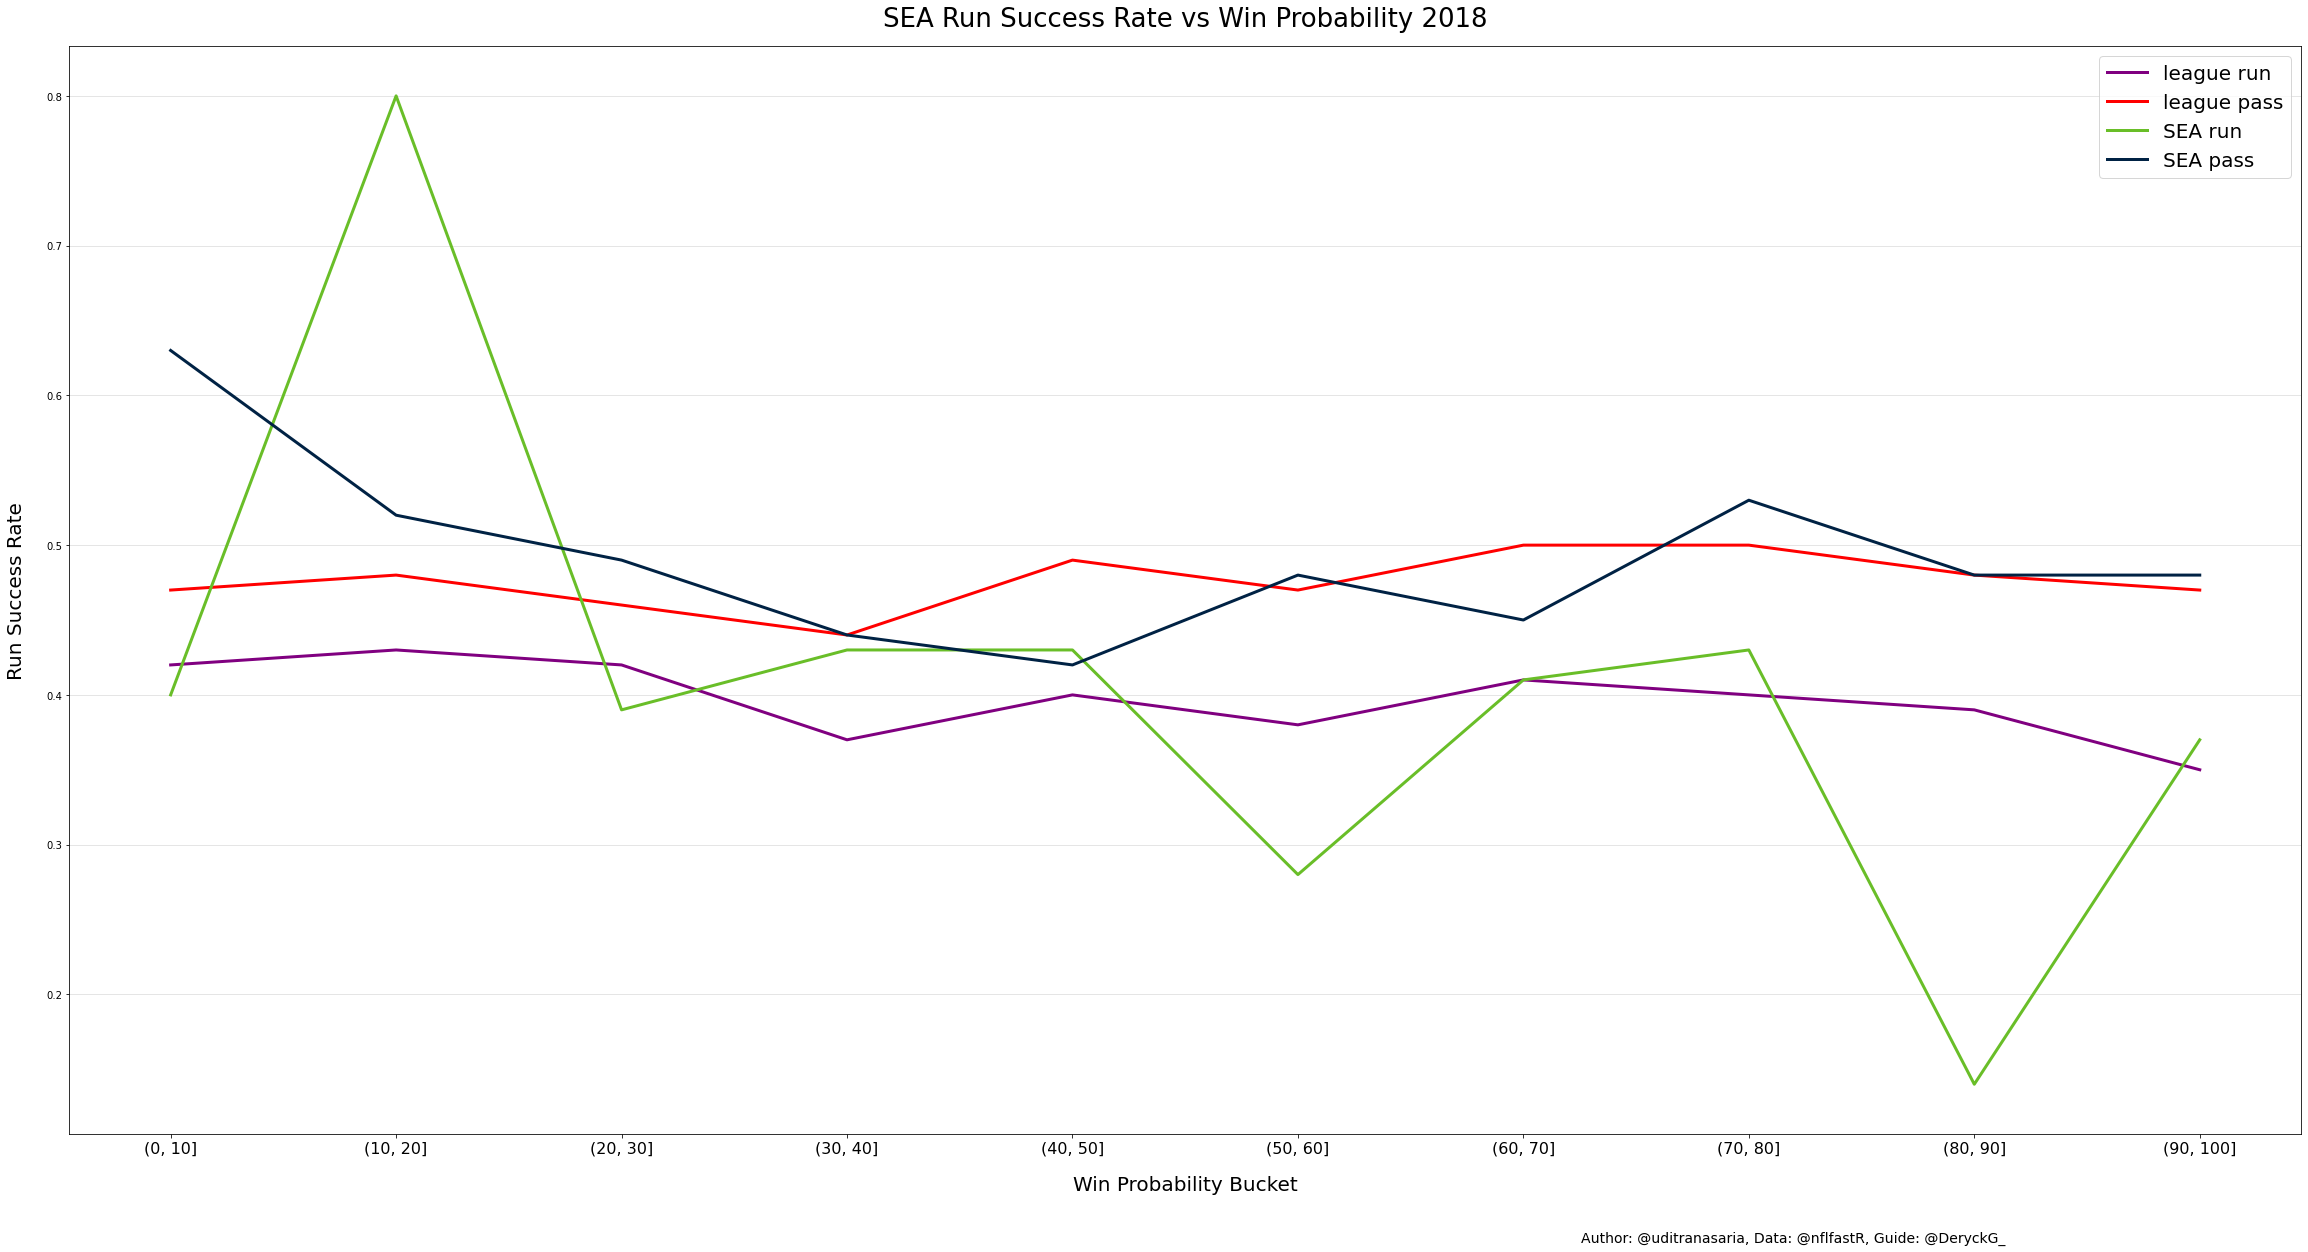

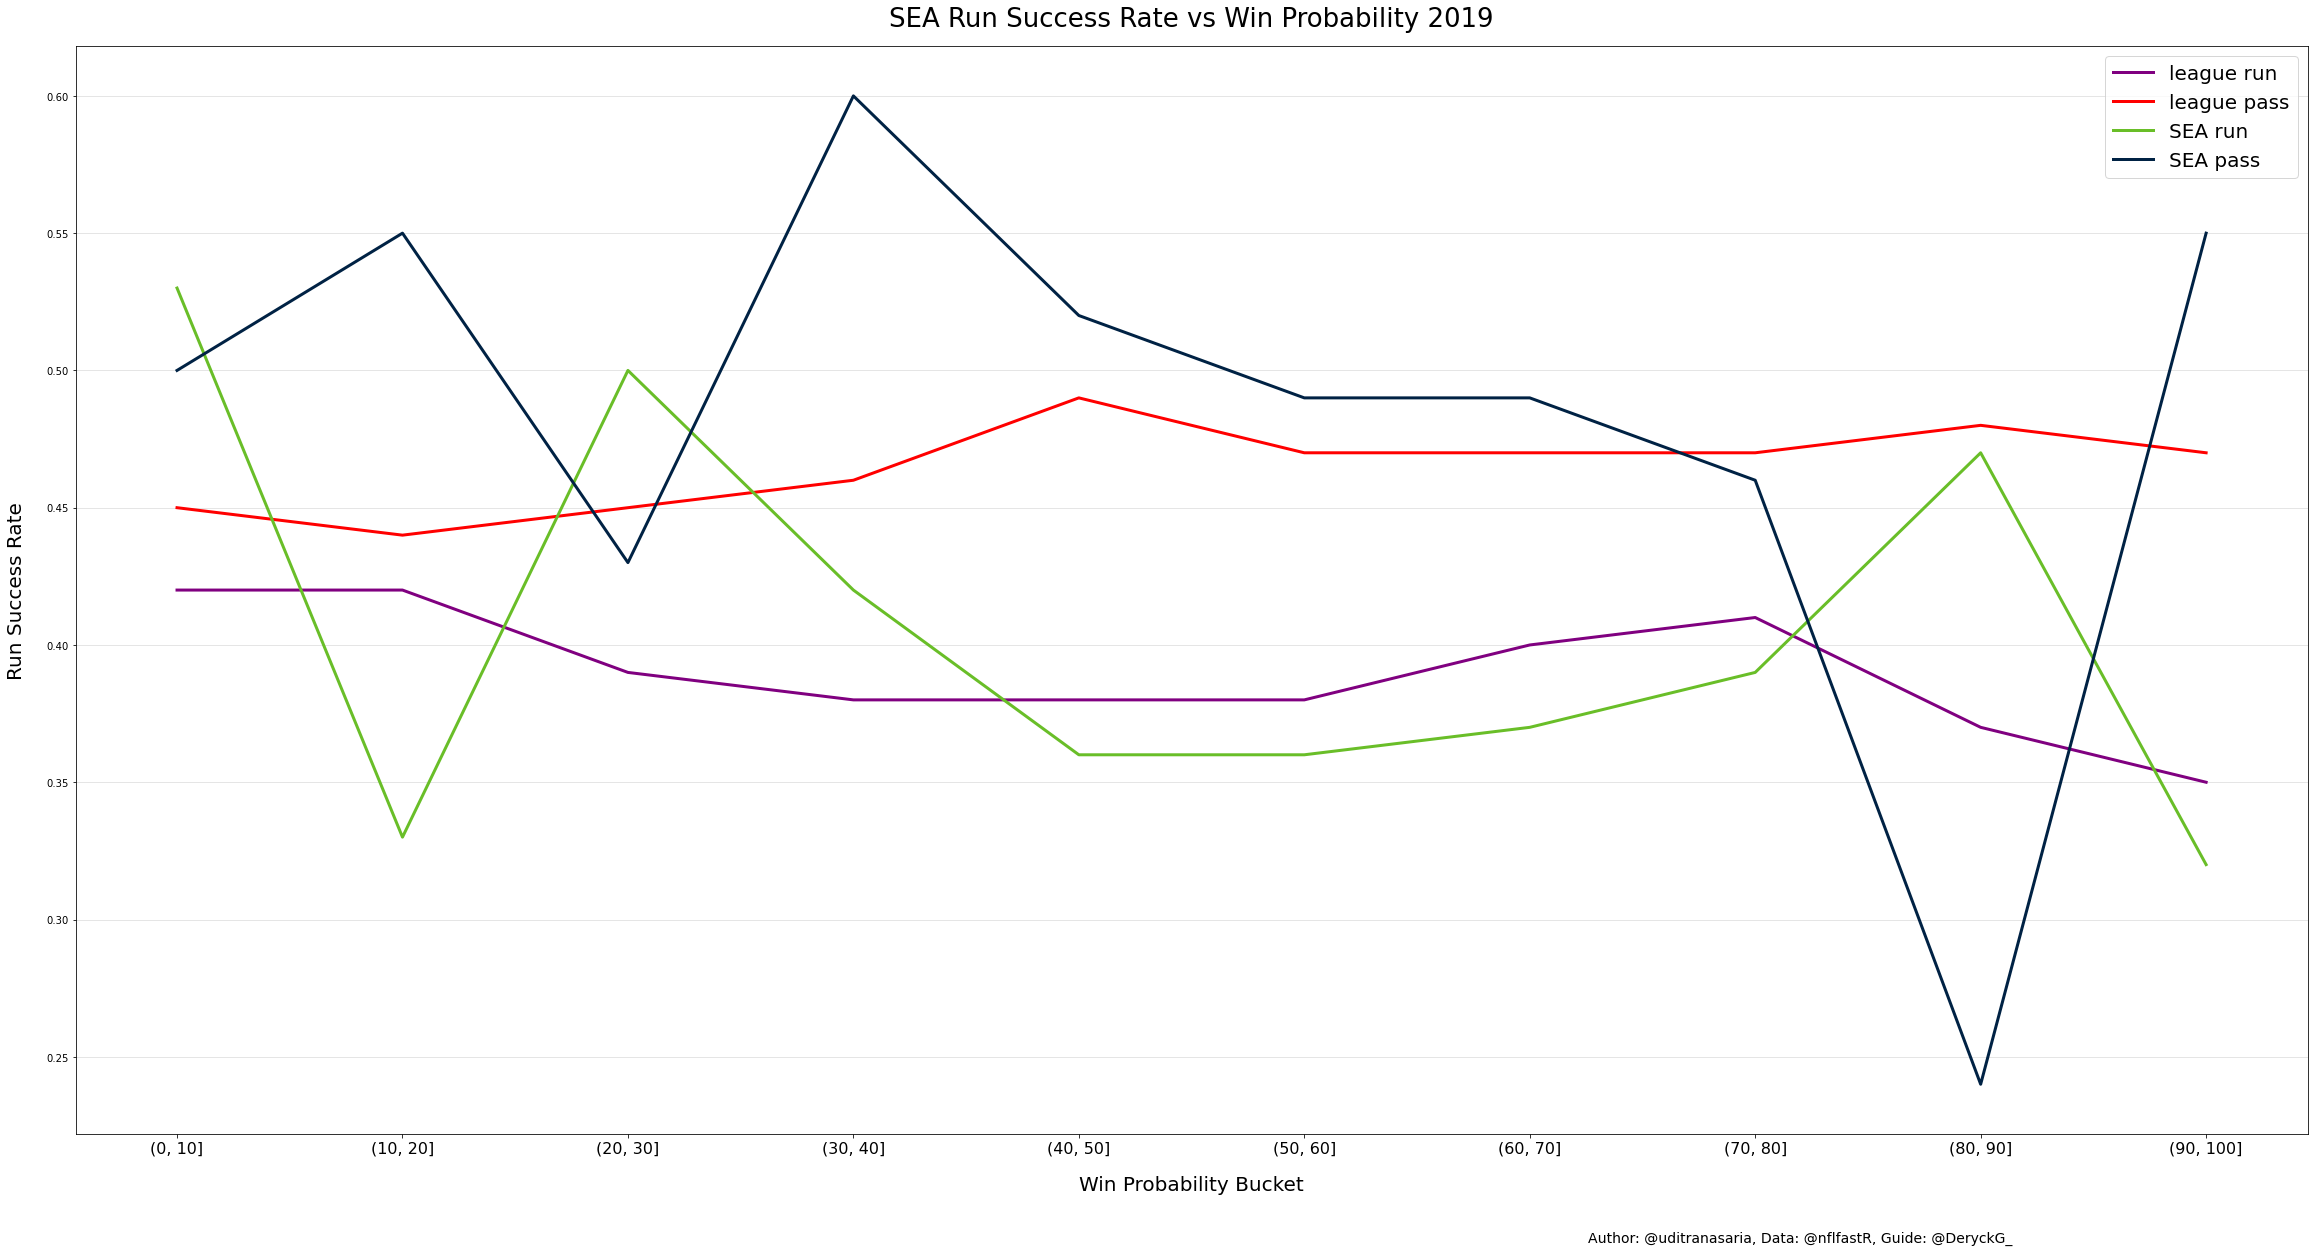

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=.5)
def trendLineString(z):
    return "y=%.6fx+(%.6f)"%(z[0],z[1])
SEA1 = '#002244'
SEA2 = '#69BE28'
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}
TEAMS = list(COLORS.keys())
# TEAMS.remove('SEA')

for year in YEARS:
    by_wp = all.loc[(all.season==year)]
    fig, ax = plt.subplots(figsize=(40,20))

    x = np.arange(0,len(wp_bins))
    y1 = np.array(by_wp['epa_succ_rate_run_lg'])
    y2 = np.array(by_wp['epa_succ_rate_run_sea'])
    y3 = np.array(by_wp['epa_succ_rate_pass_lg'])
    y4 = np.array(by_wp['epa_succ_rate_pass_sea'])
    
    ax.plot(x,y1,color='purple', label='league run', linewidth=3)
    ax.plot(x,y3,color='red', label='league pass', linewidth=3)
    ax.plot(x,y2,color=SEA2, label='SEA run', linewidth=3)
    ax.plot(x,y4,color=SEA1, label='SEA pass', linewidth=3)
    ax.set_xticks(x)
    ax.set_xticklabels(by_wp.wp.map(str), fontsize=16)

    z1 = np.polyfit(x, y1, 1)
    z2 = np.polyfit(x, y2, 1)
    z3 = np.polyfit(x, y3, 1)
    z4 = np.polyfit(x, y4, 1)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)
    p4 = np.poly1d(z4)
#     ax.plot(x, p1(x), color='black', linestyle='--', linewidth=2, alpha=0.7)
# #     print("y=%.6fx+(%.6f)"%(z1[0],z1[1]))
#     ax.plot(x, p2(x), color=SEA1, linestyle='--', linewidth=2, alpha=0.7)
#     ax.plot(x, p3(x), color='red', linestyle='--', linewidth=2, alpha=0.7)
#     ax.plot(x, p4(x), color=SEA2, linestyle='--', linewidth=2, alpha=0.7)
#     tr_line2 = trendLineString(z2)
#     plt.figtext(.75,.85,tr_line2,fontsize=16, color=COLORS[TEAM])

    ax.grid(zorder=0,alpha=.4,axis='y')
#     ax.set_ylim(0.3, 0.9)
    ax.set_axisbelow(True)
    ax.legend(fontsize=20)

#     TEAM = "ALL"
    ax.set_ylabel('Run Success Rate',fontsize=20,labelpad=20)
    ax.set_xlabel('Win Probability Bucket',fontsize=20,labelpad=20)
    title = f'SEA Run Success Rate vs Win Probability {year}'
    ax.set_title(title, fontsize=26,pad=20)
    plt.figtext(.65,.05,'Author: @uditranasaria, Data: @nflfastR, Guide: @DeryckG_',fontsize=14)

    # #League average line label
    # plt.text(31,nflavg+.01,'NFL Average',fontsize=14)
#     plt.savefig(f'./saved/PRvsWP/{title}.png', dpi=400)
    plt.show()